In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
df = pd.read_csv('resume_dataset.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \n MCA YMCAUST, Faridabad..."


In [2]:
df['category_id'] = df['Category'].factorize()[0]
df

,Category,Resume,category_id
0,Data Science,Skills * Programming Languages: Python (pandas...,0
1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...,0
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",0
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0
4,Data Science,"Education Details \n MCA YMCAUST, Faridabad...",0
...,...,...,...
164,Testing,Computer Skills: â¢ Proficient in MS office (...,24
165,Testing,â Willingness to accept the challenges. â ...,24
166,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",24
167,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,24


# Extract text

In [3]:
# Sources from https://stackoverflow.com/questions/11087795/whitespace-gone-from-pdf-extraction-and-strange-word-interpretation
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

class PdfConverter:

    def __init__(self, file_path):
        self.file_path = file_path

    def convert_pdf_to_txt(self):
        rsrcmgr = PDFResourceManager()
        retstr = StringIO()
        codec = 'utf-8'  # 'utf16','utf-8'
        laparams = LAParams()
        device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        fp = open(self.file_path, 'rb')
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()
        for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
            interpreter.process_page(page)
        fp.close()
        device.close()
        str = retstr.getvalue()
        retstr.close()
        return str

    def save_convert_pdf_to_txt(self):
        content = self.convert_pdf_to_txt()
        txt_pdf = open('text_pdf.txt', 'wb')
        txt_pdf.write(content.encode('utf-8'))
        txt_pdf.close()
# if __name__ == '__main__':
pdfConverter = PdfConverter(file_path='Huy\'s+Resume.pdf')
my_resume = pdfConverter.convert_pdf_to_txt()

# Model Selection

In [4]:
# Calculate Term Frequency, Inverse Document Frequency
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm = 'l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# X = tfidf.fit_transform(df['Resume']).toarray()
y = df['category_id']

In [5]:
# from sklearn.feature_selection import chi2

# N = 2
# category_id_df = df[['Category','ID']].drop_duplicates().sort_values('ID')
# category_to_id = dict(category_id_df.values)
# for Category, ID in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == ID)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Category))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

## Data analysis and Visualization

### Lemmatize Dataset

In [6]:
%%time
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

resumes = list(df['Resume'])
lemmatizer = WordNetLemmatizer()
resumes_lemmatized = [' '.join(lemmatizer.lemmatize(word)
    for word in nltk.word_tokenize(resume.lower().encode('ascii',errors='ignore').decode('ascii')))
    for resume in resumes]
print(resumes_lemmatized[0])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TDC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


skill * programming language : python ( panda , numpy , scipy , scikit-learn , matplotlib ) , sql , java , javascript/jquery . * machine learning : regression , svm , nave bayes , knn , random forest , decision tree , boosting technique , cluster analysis , word embedding , sentiment analysis , natural language processing , dimensionality reduction , topic modelling ( lda , nmf ) , pca & neural net . * database visualization : mysql , sqlserver , cassandra , hbase , elasticsearch d3.js , dc.js , plotly , kibana , matplotlib , ggplot , tableau . * others : regular expression , html , cs , angular 6 , logstash , kafka , python flask , git , docker , computer vision - open cv and understanding of deep learning.education detail data science assurance associatedata science assurance associate - ernst & young llpskill detail javascript- exprience - 24 month jquery- exprience - 24 month python- exprience - 24 monthscompany detail company - ernst & young llp description - fraud investigation a

### Generate Word Cloud

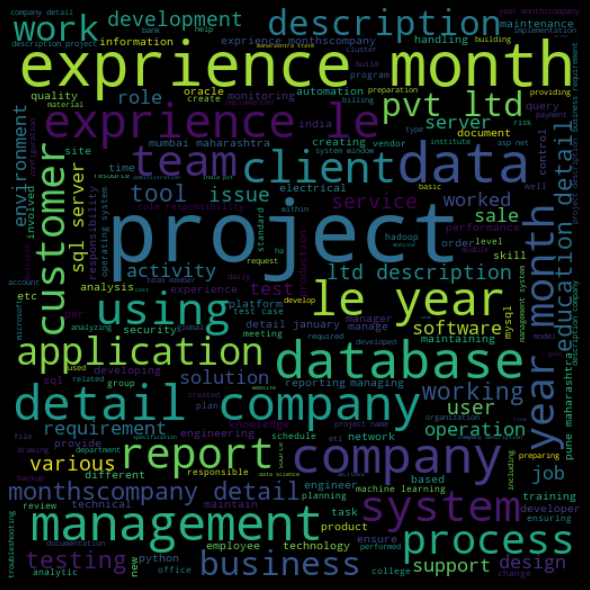

In [7]:
from wordcloud import WordCloud
%matplotlib inline

all_words = ''.join(list(resumes_lemmatized))
spam_wordcloud = WordCloud(width=512, height=512).generate(all_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = count_vectorizer.fit_transform(resumes_lemmatized).toarray()
X.shape

(169, 6942)

In [9]:
def vectorize_text(resume: str, count_vectorizer) -> np.ndarray:
    lemmatizer = WordNetLemmatizer()
    resume_lemmatized = [' '.join(lemmatizer.lemmatize(word)
        for word in nltk.word_tokenize(resume.lower()))]
#     count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
    X = count_vectorizer.transform(resume_lemmatized).toarray()
    return X

## Evaluate ensemble versus traditional methods

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV

In [11]:
def test_classification(X, y):
    # Check classification for various parameter settings.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    models = [
        RandomForestClassifier(),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(),
    ]

    for clf in models:
#         for params in grid:
        scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
        bagging_clf = BaggingClassifier(base_estimator=clf, random_state=42, max_samples=1, max_features=4, bootstrap=True, bootstrap_features=False)
        bagging_scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
        print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]'.format(clf.__class__.__name__, 
                   scores.mean(), scores.std()))
        print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n'.format(clf.__class__.__name__, 
                    bagging_scores.mean(), bagging_scores.std()))

import warnings
warnings.filterwarnings("ignore")
test_classification(X, y)

Mean of: 0.511, std: (+/-) 0.130 [RandomForestClassifier]
Mean of: 0.584, std: (+/-) 0.311 [Bagging RandomForestClassifier]

Mean of: 0.750, std: (+/-) 0.137 [LinearSVC]
Mean of: 0.808, std: (+/-) 0.194 [Bagging LinearSVC]

Mean of: 0.655, std: (+/-) 0.107 [MultinomialNB]
Mean of: 0.741, std: (+/-) 0.242 [Bagging MultinomialNB]

Mean of: 0.747, std: (+/-) 0.136 [LogisticRegression]
Mean of: 0.840, std: (+/-) 0.175 [Bagging LogisticRegression]



It seems that Bagging method does produces higher validation scores, but also induces higher variances that may needed to be consider

We will try 3 model: `LinearSVC`, `MultinomialNB`, `LogisticRegression` (Bagged and non bagged)

### Trials on LinearSVC

In [12]:
params_grid = {'max_samples': [0.5, 1.0],
               'max_features': [1, 4, 10],
               'bootstrap': [True, False],
               'bootstrap_features': [True, False]}
bagging_linear_clf = BaggingClassifier(base_estimator=LinearSVC())
bagging_linear_clf_cv = GridSearchCV(bagging_linear_clf, params_grid)
bagging_linear_clf_cv.fit(X, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=LinearSVC(C=1.0,
                                                                  class_weight=None,
                                                                  dual=True,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  loss='squared_hinge',
                                                                  max_iter=1000,
                                                                  multi_class='ovr',
                                                                  penalty='l2',
                                                                  random_state=None,
                                                                  tol=0.0001,
                                      

In [13]:
vectorize_text(my_resume, count_vectorizer)

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
optimal_params = bagging_linear_clf_cv.best_params_
bagging_linear_clf = BaggingClassifier(base_estimator=LinearSVC(), **optimal_params)
bagging_linear_clf.fit(X, y)
y_predict = bagging_linear_clf.predict(vectorize_text(my_resume, count_vectorizer))

In [25]:
df.loc[df['category_id'] == y_predict[0]]

,Category,Resume,category_id
64,Java Developer,Education Details \nAugust 2010 to May 2017 BE...,9
65,Java Developer,Technical Skills (Trained / Project Acquired S...,9
66,Java Developer,"TECHNICAL SKILLS Skills: Java, SQL, PL/SQL, C,...",9
67,Java Developer,TECHNICAL STRENGTHS Computer Language Java/J2E...,9
68,Java Developer,Education Details \nJanuary 2013 Master of Eng...,9
69,Java Developer,Education Details \n BE IT pjlceJava Develop...,9
70,Java Developer,"TECHNICALSKILLS SpringMVC, Hibernate, JDBC, Ja...",9
71,Java Developer,"TECHNICALSKILLS SpringMVC, Hibernate, JDBC, Ja...",9
72,Java Developer,"Operating Systems Windows XP, 7, 10. Tools/Pac...",9
73,Java Developer,"Computer Skills: Languages And Script: JSP, Se...",9


## Logistic Regression

In [20]:
params_grid = {"solver" : ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}

lg_clf = LogisticRegression()
lg_clf_cv = GridSearchCV(lg_clf, pagrams_grid)
lg_clf_cv.fit(X,y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
optimal_params = lg_clf_cv.best_params_
lg_clf = LogisticRegression(**optimal_params)
lg_clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_predict = lg_clf.predict(vectorize_text(my_resume, count_vectorizer))

In [33]:
df.loc[df['category_id'] == y_predict[0]]

,Category,Resume,category_id
0,Data Science,Skills * Programming Languages: Python (pandas...,0
1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...,0
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",0
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0
4,Data Science,"Education Details \n MCA YMCAUST, Faridabad...",0
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",0
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,0
7,Data Science,Education Details \n B.Tech Rayat and Bahra ...,0
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,0
9,Data Science,Expertise â Data and Quantitative Analysis â...,0


## Naive Bayes

In [34]:
multi_NB = MultinomialNB()
multi_NB.fit(X,y)
y_predict = multi_NB.predict(vectorize_text(my_resume, count_vectorizer))

In [35]:
df.loc[df['category_id'] == y_predict[0]]

,Category,Resume,category_id
0,Data Science,Skills * Programming Languages: Python (pandas...,0
1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...,0
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",0
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0
4,Data Science,"Education Details \n MCA YMCAUST, Faridabad...",0
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",0
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,0
7,Data Science,Education Details \n B.Tech Rayat and Bahra ...,0
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,0
9,Data Science,Expertise â Data and Quantitative Analysis â...,0
